In [22]:
import pathlib
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import tqdm

In [2]:
dataset_root = pathlib.Path("./processed_data/")
train_root = dataset_root.joinpath("train")
val_root = dataset_root.joinpath("val")
test_root = dataset_root.joinpath("test")

In [3]:
train_paths = list(train_root.glob("**/*.npy"))
val_paths = list(val_root.glob("**/*.npy"))
test_paths = list(test_root.glob("**/*.npy"))
print(f"Train samples: {len(train_paths)}, Validation samples: {len(val_paths)}, Test samples: {len(test_paths)}")

Train samples: 60000, Validation samples: 100, Test samples: 9900


In [4]:
train_paths[:2]

[PosixPath('processed_data/train/5/8862.npy'),
 PosixPath('processed_data/train/5/13078.npy')]

In [5]:
class OddMnist(Dataset):
    """Odd Mnist dataset."""

    def __init__(self, data_root: str):
        self.sample_paths = list(train_root.glob("**/*.npy"))

    def __len__(self):
        return len(self.sample_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path = self.sample_paths[idx]
        groups = re.match("processed_data/(\w+)/(\d+)/.*npy", str(path)).groups()
        label = int(groups[1])
        return np.load(path), label



(10, 28, 28)
(10, 28, 28)
(10, 28, 28)
(10, 28, 28)


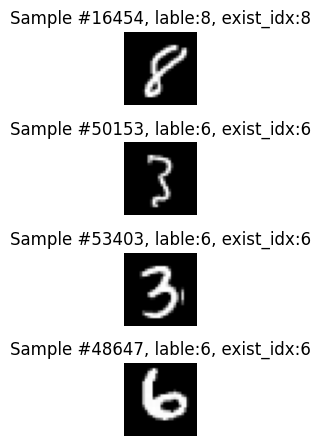

In [11]:
def show_examples(dataset):
    rand_idxs = np.random.randint(0, len(dataset), size=4)
    for i, idx in enumerate(rand_idxs):
        sample, label = dataset[idx]
        # print(sample, label)
        ax = plt.subplot(4, 1, i + 1)
        plt.tight_layout()
        print(sample.shtrange(N) can be also used as a convenient shortcut for tqdm(range(N)).ape)
        ax.axis('off')
        for j in range(len(sample)):
            if sample[j].any():
                ax.set_title(f'Sample #{idx}, lable:{label}, exist_idx:{j}')
                plt.imshow(sample[j], cmap=plt.cm.gray)
        if idx == 3:
            plt.show()
            break

train_dataset = OddMnist(train_root)
show_examples(train_dataset)

In [25]:
train_list = np.zeros((60000, 10, 28, 28))
for idx, (sample, label) in tqdm.notebook.tqdm(enumerate(train_dataset)):
    train_list[idx] = sample

0it [00:00, ?it/s]

In [32]:
np.save("train_mean.npy", np.mean(train_list, axis=0))

In [33]:
# np.std(train_list, axis=0)
np.save("train_std.npy", np.std(train_list, axis=0))

In [ ]:
train_list

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = torch.nn.Sequential(
            nn.Conv2d(10, 32, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1600, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(),
        )
    def forward(self, X):
        return self.seq(X)


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args["dry_run"]:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


def main():
    # Training settings
    args = {
        "seed": 1,
        "batch_size": 64,
        "test_batch_size": 64,
        "lr": 1,
         "gamma": 0.7,
        "log_interval": 10000,
        "epochs": 10,
        "save_model": True,
        "dry_run": False
    }
    use_cuda = torch.cuda.is_available()
    train_dataset = OddMnist(train_root)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)

    torch.manual_seed(args["seed"])

    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args["batch_size"]}
    test_kwargs = {'batch_size': args["test_batch_size"]}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    train_dataset = OddMnist(train_root)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
    
    test_dataset = OddMnist(test_root)
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=0)

    model = Model().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])

    scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
    losss = []
    for epoch in range(1, args["epochs"] + 1):
        train(args, model, device, train_dataloader, optimizer, epoch)
        l = test(model, device, test_dataloader)
        losss.append(l)
        scheduler.step()
    plt.plot(losss)
    if args["save_model"]:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()


/home/abao/.pyenv/versions/3.10.13/envs/algorithms/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284913


KeyboardInterrupt: 